# An Introduction to Redshift ML BYOM Remote Inference using SageMaker Random Cut Forests¶
Unsupervised anomaly detection on timeseries data a Random Cut Forest algorithm.

Introduction
Setup
Training
Inference
Redshift ML BYOM Remote Inference
Epilogue

# Introduction
***

Amazon SageMaker Random Cut Forest (RCF) is an algorithm designed to detect anomalous data points within a dataset. Examples of when anomalies are important to detect include when website activity uncharactersitically spikes, when temperature data diverges from a periodic behavior, or when changes to public transit ridership reflect the occurrence of a special event.

In this notebook, we will use the SageMaker RCF algorithm to train an RCF model on the Numenta Anomaly Benchmark (NAB) NYC Taxi dataset which records the amount New York City taxi ridership over the course of six months. We will then use this model to predict anomalous events by emitting an "anomaly score" for each data point. The main goals of this notebook are,

* to learn how to obtain, transform, and store data for use in Amazon SageMaker;
* to create an AWS SageMaker training job on a data set to produce an RCF model,
* use the RCF model to perform inference with an Amazon SageMaker endpoint.

The following are ***not*** goals of this notebook:

* deeply understand the RCF model,
* understand how the Amazon SageMaker RCF algorithm works.

If you would like to know more please check out the [SageMaker RCF Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/randomcutforest.html).

# Setup

***

*This notebook was tested in Amazon SageMaker Studio on a ml.t3.medium instance with Python 3 (Data Science) kernel.*

Our first step is to setup our AWS credentials so that AWS SageMaker can store and access training data and model artifacts. We also need some data to inspect and to train upon.

## Select Amazon S3 Bucket

We first need to specify the locations where the original data is stored and where we will store our training data and trained model artifacts. ***This is the only cell of this notebook that you will need to edit.*** In particular, we need the following data:

* `bucket` - An S3 bucket accessible by this account.
* `prefix` - The location in the bucket where this notebook's input and output data will be stored. (The default value is sufficient.)
* `downloaded_data_bucket` - An S3 bucket where data is downloaded from this [link](https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv) and stored.
* `downloaded_data_prefix` - The location in the bucket where the data is stored.

In [1]:
import boto3
import botocore
import sagemaker
import sys


bucket = (
    sagemaker.Session().default_bucket()
)  # Feel free to change to another bucket you have access to
prefix = "sagemaker/rcf-benchmarks"
execution_role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# S3 bucket where the original data is downloaded and stored.
downloaded_data_bucket = f"sagemaker-sample-files"
downloaded_data_prefix = "datasets/tabular/anomaly_benchmark_taxi"


def check_bucket_permission(bucket):
    # check if the bucket exists
    permission = False
    try:
        boto3.Session().client("s3").head_bucket(Bucket=bucket)
    except botocore.exceptions.ParamValidationError as e:
        print(
            "Hey! You either forgot to specify your S3 bucket"
            " or you gave your bucket an invalid name!"
        )
    except botocore.exceptions.ClientError as e:
        if e.response["Error"]["Code"] == "403":
            print(f"Hey! You don't have permission to access the bucket, {bucket}.")
        elif e.response["Error"]["Code"] == "404":
            print(f"Hey! Your bucket, {bucket}, doesn't exist!")
        else:
            raise
    else:
        permission = True
    return permission


if check_bucket_permission(bucket):
    print(f"Training input/output will be stored in: s3://{bucket}/{prefix}")
if check_bucket_permission(downloaded_data_bucket):
    print(
        f"Downloaded training data will be read from s3://{downloaded_data_bucket}/{downloaded_data_prefix}"
    )

Training input/output will be stored in: s3://sagemaker-us-east-1-845897987212/sagemaker/rcf-benchmarks
Downloaded training data will be read from s3://sagemaker-sample-files/datasets/tabular/anomaly_benchmark_taxi


## Obtain and Inspect Example Data


Our data comes from the Numenta Anomaly Benchmark (NAB) NYC Taxi dataset [[1](https://github.com/numenta/NAB/blob/master/data/realKnownCause/nyc_taxi.csv)]. We downloaded data from [here](https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv) and stored in an S3 bucket. These data consists of the number of New York City taxi passengers over the course of six months aggregated into 30-minute buckets. We know, a priori, that there are anomalous events occurring during the NYC marathon, Thanksgiving, Christmas, New Year's day, and on the day of a snow storm.

> [1] https://github.com/numenta/NAB/blob/master/data/realKnownCause/nyc_taxi.csv

In [2]:
%%time

import pandas as pd

data_filename = "NAB_nyc_taxi.csv"
s3 = boto3.client("s3")
s3.download_file(downloaded_data_bucket, f"{downloaded_data_prefix}/{data_filename}", data_filename)
taxi_data = pd.read_csv(data_filename, delimiter=",")

CPU times: user 155 ms, sys: 12.3 ms, total: 167 ms
Wall time: 267 ms


Before training any models it is important to inspect our data, first. Perhaps there are some underlying patterns or structures that we could provide as "hints" to the model or maybe there is some noise that we could pre-process away. The raw data looks like this:

In [3]:
taxi_data.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


Human beings are visual creatures so let's take a look at a plot of the data.

<AxesSubplot:>

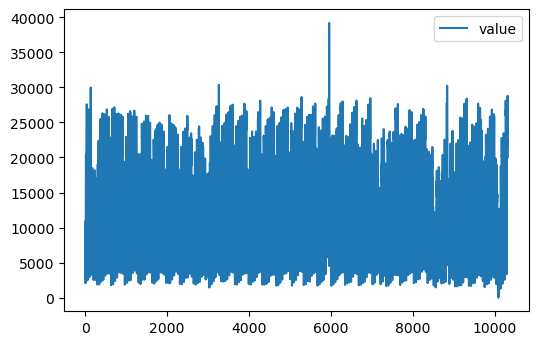

In [4]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.dpi"] = 100

taxi_data.plot()

Human beings are also extraordinarily good at perceiving patterns. Note, for example, that something uncharacteristic occurs at around datapoint number 6000. Additionally, as we might expect with taxi ridership, the passenger count appears more or less periodic. Let's zoom in to not only examine this anomaly but also to get a better picture of what the "normal" data looks like.

<AxesSubplot:>

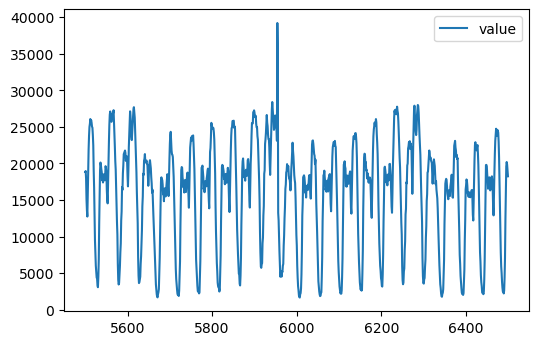

In [5]:
taxi_data[5500:6500].plot()

Here we see that the number of taxi trips taken is mostly periodic with one mode of length approximately 50 data points. In fact, the mode is length 48 since each datapoint represents a 30-minute bin of ridership count. Therefore, we expect another mode of length $336 = 48 \times 7$, the length of a week. Smaller frequencies over the course of the day occur, as well.

For example, here is the data across the day containing the above anomaly:

In [6]:
taxi_data[5952:6000]

,timestamp,value
5952,2014-11-02 00:00:00,25110
5953,2014-11-02 00:30:00,23109
5954,2014-11-02 01:00:00,39197
5955,2014-11-02 01:30:00,35212
5956,2014-11-02 02:00:00,13259
5957,2014-11-02 02:30:00,12250
5958,2014-11-02 03:00:00,10013
5959,2014-11-02 03:30:00,7898
5960,2014-11-02 04:00:00,6375
5961,2014-11-02 04:30:00,4532


# Training

***

Next, we configure a SageMaker training job to train the Random Cut Forest (RCF) algorithm on the taxi cab data.

## Hyperparameters

Particular to a SageMaker RCF training job are the following hyperparameters:

* **`num_samples_per_tree`** - the number randomly sampled data points sent to each tree. As a general rule, `1/num_samples_per_tree` should approximate the the estimated ratio of anomalies to normal points in the dataset.
* **`num_trees`** - the number of trees to create in the forest. Each tree learns a separate model from different samples of data. The full forest model uses the mean predicted anomaly score from each constituent tree.
* **`feature_dim`** - the dimension of each data point.

In addition to these RCF model hyperparameters, we provide additional parameters defining things like the EC2 instance type on which training will run, the S3 bucket containing the data, and the AWS access role. Note that,

* Recommended instance type: `ml.m4`, `ml.c4`, or `ml.c5`
* Current limitations:
  * The RCF algorithm does not take advantage of GPU hardware.

In [7]:
from sagemaker import RandomCutForest

session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(
    role=execution_role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    data_location=f"s3://{bucket}/{prefix}/",
    output_path=f"s3://{bucket}/{prefix}/output",
    num_samples_per_tree=512,
    num_trees=50,
)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(taxi_data.value.to_numpy().reshape(-1, 1)))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-09-01 12:21:49 Starting - Starting the training job...
2021-09-01 12:22:12 Starting - Launching requested ML instancesProfilerReport-1630498908: InProgress
...
2021-09-01 12:22:48 Starting - Preparing the instances for training.........
2021-09-01 12:24:17 Downloading - Downloading input data...
2021-09-01 12:24:36 Training - Downloading the training image...
2021-09-01 12:25:12 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[09/01/2021 12:25:15 INFO 139911586375488] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'num_samples_per_tree': 256, 'num_trees': 100, 'force_dense': 'true', 'eval_metrics': ['accuracy', 'precision_recall_fscore'], 'epochs': 1, 'mini_batch_size': 1000, '_log_level': 'info', '_kvstore': 'dist_async', '_num_kv_servers': 'auto', '_num_gpus': 'auto', '_tuning_objective_metric': '

[09/01/2021 12:25:17 INFO 139911586375488] Cluster sharing facilities started.
[09/01/2021 12:25:17 INFO 139911586375488] Verifying all workers are accessible...
[09/01/2021 12:25:17 INFO 139911586375488] All workers accessible.
[09/01/2021 12:25:17 INFO 139911586375488] Initializing Sampler...
[09/01/2021 12:25:17 INFO 139911586375488] Sampler correctly initialized.
#metrics {"StartTime": 1630499115.9768412, "EndTime": 1630499117.220463, "Dimensions": {"Algorithm": "RandomCutForest", "Host": "algo-1", "Operation": "training"}, "Metrics": {"initialize.time": {"sum": 1238.0080223083496, "count": 1, "min": 1238.0080223083496, "max": 1238.0080223083496}}}

#metrics {"StartTime": 1630499117.2206788, "EndTime": 1630499117.220717, "Dimensions": {"Algorithm": "RandomCutForest", "Host": "algo-1", "Operation": "training", "Meta": "init_train_data_iter"}, "Metrics": {"Total Records Seen": {"sum": 0.0, "count": 1, "min": 0, "max": 0}, "Total Batches Seen": {"sum": 0.0, "count": 1, "min": 0, "max"

If you see the message

> `===== Job Complete =====`

at the bottom of the output logs then that means training successfully completed and the output RCF model was stored in the specified output path. You can also view information about and the status of a training job using the AWS SageMaker console. Just click on the "Jobs" tab and select training job matching the training job name, below:

In [8]:
print(f"Training job name: {rcf.latest_training_job.job_name}")

Training job name: randomcutforest-2021-09-01-12-21-48-996


# Inference

***

A trained Random Cut Forest model does nothing on its own. We now want to use the model we computed to perform inference on data. In this case, it means computing anomaly scores from input time series data points.

We create an inference endpoint using the SageMaker Python SDK `deploy()` function from the job we defined above. We specify the instance type where inference is computed as well as an initial number of instances to spin up. We recommend using the `ml.c5` instance type as it provides the fastest inference time at the lowest cost.

In [9]:
rcf_inference = rcf.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-----------------!

Congratulations! You now have a functioning SageMaker RCF inference endpoint. You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console and selecting the endpoint matching the endpoint name, below: 

In [10]:
print(f"Endpoint name: {rcf_inference.endpoint}")

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Endpoint name: randomcutforest-2021-09-01-12-26-01-554


## Data Serialization/Deserialization

We can pass data in a variety of formats to our inference endpoint. In this example we will demonstrate passing CSV-formatted data. Other available formats are JSON-formatted and RecordIO Protobuf. We make use of the SageMaker Python SDK utilities `csv_serializer` and `json_deserializer` when configuring the inference endpoint.

In [11]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

rcf_inference.serializer = CSVSerializer()
rcf_inference.deserializer = JSONDeserializer()

Let's pass the training dataset, in CSV format, to the inference endpoint so we can automatically detect the anomalies we saw with our eyes in the plots, above. Note that the serializer and deserializer will automatically take care of the datatype conversion from Numpy NDArrays.

For starters, let's only pass in the first six datapoints so we can see what the output looks like.

In [12]:
taxi_data_numpy = taxi_data.value.to_numpy().reshape(-1, 1)
print(taxi_data_numpy[:6])
results = rcf_inference.predict(
    taxi_data_numpy[:6], initial_args={"ContentType": "text/csv", "Accept": "application/json"}
)

[[10844]
 [ 8127]
 [ 6210]
 [ 4656]
 [ 3820]
 [ 2873]]


## Computing Anomaly Scores

Now, let's compute and plot the anomaly scores from the entire taxi dataset.

In [13]:
results = rcf_inference.predict(taxi_data_numpy)
scores = [datum["score"] for datum in results["scores"]]

# add scores to taxi data frame and print first few values
taxi_data["score"] = pd.Series(scores, index=taxi_data.index)
taxi_data.head()

,timestamp,value,score
0,2014-07-01 00:00:00,10844,0.911797
1,2014-07-01 00:30:00,8127,0.993779
2,2014-07-01 01:00:00,6210,0.946782
3,2014-07-01 01:30:00,4656,0.912298
4,2014-07-01 02:00:00,3820,0.963720


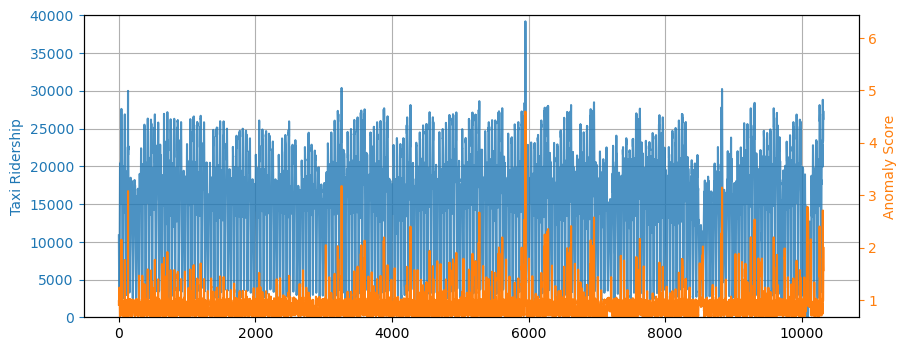

In [14]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the
# anomaly found earlier in this notebook
#
start, end = 0, len(taxi_data)
# start, end = 5500, 6500
taxi_data_subset = taxi_data[start:end]

ax1.plot(taxi_data_subset["value"], color="C0", alpha=0.8)
ax2.plot(taxi_data_subset["score"], color="C1")

ax1.grid(which="major", axis="both")

ax1.set_ylabel("Taxi Ridership", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")

ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")

ax1.set_ylim(0, 40000)
ax2.set_ylim(min(scores), 1.4 * max(scores))
fig.set_figwidth(10)

Note that the anomaly score spikes where our eyeball-norm method suggests there is an anomalous data point as well as in some places where our eyeballs are not as accurate.

Below we print and plot any data points with scores greater than 3 standard deviations (approx 99.9th percentile) from the mean score.

In [15]:
score_mean = taxi_data["score"].mean()
score_std = taxi_data["score"].std()
score_cutoff = score_mean + 3 * score_std

anomalies = taxi_data_subset[taxi_data_subset["score"] > score_cutoff]
anomalies

,timestamp,value,score
37,2014-07-01 18:30:00,27598,2.150031
38,2014-07-01 19:00:00,26827,1.740320
87,2014-07-02 19:30:00,26872,1.762190
134,2014-07-03 19:00:00,29985,3.077378
527,2014-07-11 23:30:00,26873,1.765608
...,...,...,...
10309,2015-01-31 18:30:00,27286,1.999890
10310,2015-01-31 19:00:00,28804,2.707431
10311,2015-01-31 19:30:00,27773,2.252726
10317,2015-01-31 22:30:00,27309,2.006683


The following is a list of known anomalous events which occurred in New York City within this timeframe:

* `2014-11-02` - NYC Marathon
* `2015-01-01` - New Year's Eve
* `2015-01-27` - Snowstorm

Note that our algorithm managed to capture these events along with quite a few others. Below we add these anomalies to the score plot.

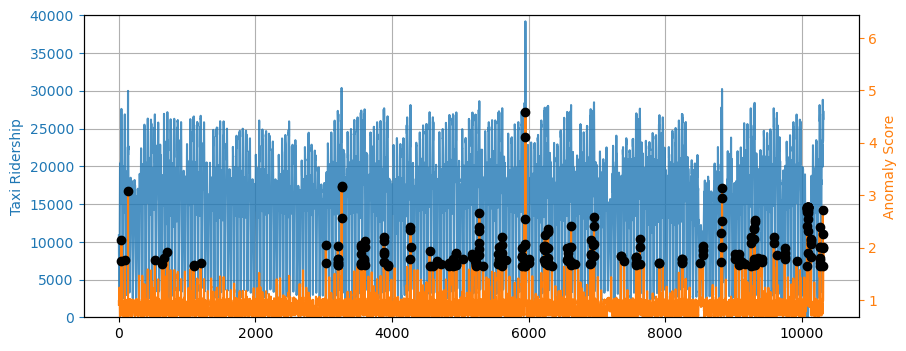

In [16]:
ax2.plot(anomalies.index, anomalies.score, "ko")
fig

With the current hyperparameter choices we see that the three-standard-deviation threshold, while able to capture the known anomalies as well as the ones apparent in the ridership plot, is rather sensitive to fine-grained peruturbations and anomalous behavior. Adding trees to the SageMaker RCF model could smooth out the results as well as using a larger data set.

## Input Redshift Cluster Endpoint and User
Please input your redshift cluster endpoint and existing user on that cluster.

In [17]:
REDSHIFT_ENDPOINT = 'redshift-cluster.xxxxxxxxxx.us-east-1.redshift.amazonaws.com:5439/dev'
REDSHIFT_USER="awsuser"

## Setup Run SQL function using Redshift Data API to get SQL query output directly into pandas dataframe
In this step, we are creating function run_sql, which we will use to get SQL query output directly into pandas dataframe. We will also use this function to run DDL statements

In [18]:

import boto3
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

session = boto3.session.Session()
region = session.region_name


def run_sql(sql_text):
    client = boto3.client("redshift-data")
    res = client.execute_statement(Database=REDSHIFT_ENDPOINT.split('/')[1], DbUser=REDSHIFT_USER, Sql=sql_text,
                                   ClusterIdentifier=REDSHIFT_ENDPOINT.split('.')[0])
    query_id = res["Id"]
    done = False
    while not done:
        time.sleep(1)
        status_description = client.describe_statement(Id=query_id)
        status = status_description["Status"]
        if status == "FAILED":
            raise Exception('SQL query failed:' + query_id + ": " + status_description["Error"])
        elif status == "FINISHED":
            if status_description['ResultRows']>0:
                results = client.get_statement_result(Id=query_id)
                column_labels = []
                for i in range(len(results["ColumnMetadata"])): column_labels.append(results["ColumnMetadata"][i]['label'])
                records = []
                for record in results.get('Records'):
                    records.append([list(rec.values())[0] for rec in record])
                df = pd.DataFrame(np.array(records), columns=column_labels)
                return df
            else:
                return query_id


## Data Preparation Script
Data preparation script to be run on Redshift
we will create the table that will be used to run inference on

In [19]:
setup_script = """

DROP TABLE IF EXISTS public.rcf_taxi_data CASCADE;

CREATE TABLE public.rcf_taxi_data
(
ride_timestamp timestamp,
nbr_passengers int
);

COPY public.rcf_taxi_data
FROM 's3://sagemaker-sample-files/datasets/tabular/anomaly_benchmark_taxi/NAB_nyc_taxi.csv'
iam_role 'arn:aws:iam:::<accountid>:role/RedshiftML' ignoreheader 1 csv delimiter ',';

"""

 


## Run data preparation script in Redshift

In [20]:
sql_stmt = setup_script.split(";")
for sql_text in sql_stmt[:-1]:
    run_sql(sql_text);

## Run Redshift ML Create Model statement using Sagemaker Endpoint for Remote Inference
Copy and paste the endpoint that was created earlier in SageMaker


In [21]:
run_sql("""

CREATE MODEL public.remote_random_cut_forest
FUNCTION remote_fn_rcf(int)
RETURNS decimal(10,6)
SAGEMAKER 'randomcutforest-xxxxxxxxx'
IAM_ROLE 'arn:aws:iam::<accountid>:role/RedshiftML';


""");

## Show Model

In [22]:
df = run_sql("SHOW MODEL public.remote_random_cut_forest")
df

,Key,Value
0,Model Name,remote_random_cut_forest
1,Schema Name,public
2,Owner,demo
3,Creation Time,"Wed, 01.09.2021 12:34:40"
4,Model State,READY
5,,
6,PARAMETERS:,
7,Endpoint,randomcutforest-2021-08-31-12-38-26-697
8,Function Name,remote_fn_rcf
9,Inference Type,Remote


## Computing Anomaly Scores
Now, let's compute and plot the anomaly scores from the entire taxi dataset.



In [23]:
df = run_sql("""
select ride_timestamp, nbr_passengers, public.remote_fn_rcf(nbr_passengers) as score
from public.rcf_taxi_data;

""");
df

,ride_timestamp,nbr_passengers,score
0,2014-07-01 00:00:00,10844,0.872600
1,2014-07-01 00:30:00,8127,1.051977
2,2014-07-01 01:00:00,6210,0.968547
3,2014-07-01 01:30:00,4656,0.848564
4,2014-07-01 02:00:00,3820,0.930401
...,...,...,...
10315,2015-01-31 21:30:00,24670,1.119624
10316,2015-01-31 22:00:00,25721,1.455056
10317,2015-01-31 22:30:00,27309,2.058410
10318,2015-01-31 23:00:00,26591,1.728696



Note that the anomaly score spikes where our eyeball-norm method suggests there is an anomalous data point as well as in some places where our eyeballs are not as accurate.

Below we print any data points with scores greater than 3 standard deviations (approx 99.9th percentile) from the mean score.

In [24]:
df = run_sql("""
with score_cutoff as
(select stddev(public.remote_fn_rcf(nbr_passengers)) as std, avg(public.remote_fn_rcf(nbr_passengers)) as mean, ( mean + 3 * std ) as score_cutoff_value
from public.rcf_taxi_data)

select ride_timestamp, nbr_passengers, public.remote_fn_rcf(nbr_passengers) as score
from public.rcf_taxi_data
where score > (select score_cutoff_value from score_cutoff)


""");
df

,ride_timestamp,nbr_passengers,score
0,2014-07-01 18:30:00,27598,2.242393
1,2014-07-01 19:00:00,26827,1.829029
2,2014-07-02 19:30:00,26872,1.839331
3,2014-07-03 19:00:00,29985,3.178867
4,2014-07-11 23:30:00,26873,1.838771
...,...,...,...
207,2015-01-31 18:30:00,27286,2.035598
208,2015-01-31 19:00:00,28804,2.797991
209,2015-01-31 19:30:00,27773,2.323909
210,2015-01-31 22:30:00,27309,2.058410


# Conclusion

---

We used Amazon SageMaker Random Cut Forest to detect anomalous datapoints in a taxi ridership dataset. In these data the anomalies occurred when ridership was uncharacteristically high or low. However, the RCF algorithm is also capable of detecting when, for example, data breaks periodicity or uncharacteristically changes global behavior.

We then used Redshift ML to demonstrate how you can do inference on unsupervised algorithms(such as Random Cut Forest).  This allows you to democratize Machine learning by doing predictions with Redshift SQL Commands.
